# Melhor modelo - Regressão Logística

Após as submissões das predições dos 3 modelos iniciais ao Kaggle, verificou-se que o modelo que obteve a maior acurácia foi a regressão logística. 

Nessa segunda etapa, a regressão logística será retreinada, dessa vez utilizando 70% do conjunto de treino para treinamento do modelo e os 30% restantes para o teste. Esse foi o meio encontrado para realizar avaliações mais profundas do modelo, visto que o conjunto de teste disponibilizado não contém a classe dos exemplos. 

Para esse modelo, também será utilizado o GridSearch para testar algumas combinações de parâmetros do modelo, de modo a se obter o modelo de melhor score.

Por fim, o modelo de melhor score será testado e seus resultados estarão no final deste notebook.

### Imports

#### Importação das bibliotecas utilizadas

In [64]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
import pickle
import numpy as np
import matplotlib.pyplot as plt
import itertools 

#### Importação do conjunto de treinamento e teste

O conjuntos de treinamento e de teste estão em formato JSON, portando é necessário usar a função __read_json__ do pandas para realizar a leitura dos arquivos:

In [2]:
train = pd.read_csv('../dados/train/processed_train_scaled.csv', encoding='utf-8')
train_target = pd.read_csv('../dados/train/train_target.csv', encoding='utf-8')

In [3]:
# visualização das cinco primeira receitas presentes no conjunto de treino
train.head(2)

,cuisine,id,ingredients,ingredients_text,ingredients_qtt,0,1,2,3,4,...,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730
0,greek,10259,"['romaine lettuce', 'seasoning', 'grape tomato...",romaine lettuce seasoning grape tomato purple ...,9,-0.400044,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,-0.144463,-0.023507,-0.016558,-0.030612,-0.150551
1,southern_us,25693,"['milk', 'ground pepper', 'thyme', 'salt', 'gr...",milk ground pepper thyme salt ground black pep...,11,0.051786,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,-0.144463,-0.023507,-0.016558,-0.030612,-0.150551


### Modelagem

Os seguintes tratamentos serão realizados nos dois conjuntos de dados:

In [17]:
# divide o conjunto de treino original de modo que 70% dele seja utilizado para treino e o restante como teste
X_train, X_test, y_train, y_test = train_test_split(train, train_target, train_size=0.7, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
X_train.head()

,cuisine,id,ingredients,ingredients_text,ingredients_qtt,0,1,2,3,4,...,2721,2722,2723,2724,2725,2726,2727,2728,2729,2730
29243,irish,14649,"['freshly ground pepper', 'baking soda', 'larg...",freshly ground pepper baking soda large egg ba...,14,0.729530,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,-0.144463,-0.023507,-0.016558,-0.030612,-0.150551
13883,italian,13982,"['minced garlic', 'grated parmesan cheese', 's...",minced garlic grated parmesan cheese scallion ...,16,1.181360,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,6.031758,-0.023507,-0.016558,-0.030612,-0.150551
27267,moroccan,22010,"['lentil', 'chickpea', 'cinnamon', 'black pepp...",lentil chickpea cinnamon black pepper lemon di...,17,1.407275,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,-0.144463,-0.023507,-0.016558,-0.030612,-0.150551
9653,italian,27750,"['royal olive', 'minced garlic', 'fennel', 'th...",royal olive minced garlic fennel thyme chili f...,14,0.729530,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,-0.144463,-0.023507,-0.016558,-0.030612,-0.150551
4408,mexican,34397,"['corn tortilla', 'iceberg lettuce', 'crema me...",corn tortilla iceberg lettuce crema mexican to...,12,0.277700,-0.007086,-0.00502,-0.00502,-0.009889,...,-0.007019,-0.007093,-0.00502,-0.00502,-0.007095,-0.144463,-0.023507,-0.016558,-0.030612,-0.150551


In [6]:
X_train = X_train.drop(['cuisine','id','ingredients','ingredients_text','ingredients_qtt'], axis=1)

In [7]:
logit = LogisticRegression(random_state=42) 

In [8]:
model = OneVsRestClassifier(logit)

# diversos parâmetros que serão testados no GridSearch para a regressão logística
parameters = [
  {'estimator__C': [0.1,1,10],
             'estimator__penalty':['l2'],     
             'estimator__solver':['lbfgs']},
  {'estimator__C': [0.1,1,10],
             'estimator__penalty':['l2','l1'],     
             'estimator__solver':['saga']}
 ]

grid_obj = GridSearchCV(model,parameters, scoring = 'f1_weighted', verbose=3)
grid_fit = grid_obj.fit(X_train, y_train)

melhor_modelo = grid_fit.best_estimator_
melhor_modelo

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs, score=0.7449282443435067, total= 2.4min
[CV] estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

[CV]  estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs, score=0.7435055581950883, total= 2.4min
[CV] estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.8min remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

[CV]  estimator__C=0.1, estimator__penalty=l2, estimator__solver=lbfgs, score=0.7439139831131051, total= 2.4min
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs, score=0.7233515315019221, total= 2.5min
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs, score=0.7217766250068127, total= 2.4min
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=lbfgs, score=0.7212901301131969, total= 2.3min
[CV] estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs, score=0.698619508926701, total= 2.4min
[CV] estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs, score=0.6998207973139351, total= 2.4min
[CV] estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

[CV]  estimator__C=10, estimator__penalty=l2, estimator__solver=lbfgs, score=0.699273027339977, total= 2.3min
[CV] estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga, score=0.7540341170089238, total=13.2min
[CV] estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga, score=0.7588356525817532, total=11.7min
[CV] estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=0.1, estimator__penalty=l2, estimator__solver=saga, score=0.75082884979514, total=11.4min
[CV] estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga, score=0.7555801164497665, total=19.9min
[CV] estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga, score=0.7573888797086418, total=20.1min
[CV] estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga .


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=0.1, estimator__penalty=l1, estimator__solver=saga, score=0.7527231103704232, total=19.4min
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=saga ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=saga, score=0.7541016388337671, total=11.1min
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=saga ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=saga, score=0.7589708752357786, total=11.1min
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=saga ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=saga, score=0.750886275582026, total=11.5min
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=saga ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=saga, score=0.7526474720033229, total=23.2min
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=saga ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=saga, score=0.7581891544811695, total=23.4min
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=saga ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=saga, score=0.7512115727005904, total=22.8min
[CV] estimator__C=10, estimator__penalty=l2, estimator__solver=saga ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=10, estimator__penalty=l2, estimator__solver=saga, score=0.7541016388337671, total=11.3min
[CV] estimator__C=10, estimator__penalty=l2, estimator__solver=saga ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=10, estimator__penalty=l2, estimator__solver=saga, score=0.7589708752357786, total=11.3min
[CV] estimator__C=10, estimator__penalty=l2, estimator__solver=saga ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=10, estimator__penalty=l2, estimator__solver=saga, score=0.750886275582026, total=11.1min
[CV] estimator__C=10, estimator__penalty=l1, estimator__solver=saga ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=10, estimator__penalty=l1, estimator__solver=saga, score=0.7525711932758768, total=21.0min
[CV] estimator__C=10, estimator__penalty=l1, estimator__solver=saga ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=10, estimator__penalty=l1, estimator__solver=saga, score=0.7584899808329935, total=22.3min
[CV] estimator__C=10, estimator__penalty=l1, estimator__solver=saga ..


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

[CV]  estimator__C=10, estimator__penalty=l1, estimator__solver=saga, score=0.7511595714667434, total=22.6min


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 320.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The m

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)

In [9]:
with open('../models/logit_best.pkl', 'wb') as local_model_file:
    pickle.dump(melhor_modelo, local_model_file)

### Predições para o conjunto de teste e resultados

In [21]:
test = X_test.copy()
X_test = X_test.drop(['id','ingredients','ingredients_text','ingredients_qtt', 'cuisine'], axis=1)

In [22]:
y_pred_test = melhor_modelo.predict(X_test)

Como as classes foram encodificadas para serem fornecidas para o modelo. É necessário fazer a decodificação:

In [12]:
encoder = LabelEncoder()
classes = encoder.fit_transform(train.cuisine)

In [13]:
list(zip(encoder.classes_, encoder.transform(encoder.classes_)))

[('brazilian', 0),
 ('british', 1),
 ('cajun_creole', 2),
 ('chinese', 3),
 ('filipino', 4),
 ('french', 5),
 ('greek', 6),
 ('indian', 7),
 ('irish', 8),
 ('italian', 9),
 ('jamaican', 10),
 ('japanese', 11),
 ('korean', 12),
 ('mexican', 13),
 ('moroccan', 14),
 ('russian', 15),
 ('southern_us', 16),
 ('spanish', 17),
 ('thai', 18),
 ('vietnamese', 19)]

In [14]:
y_test_decoded = encoder.inverse_transform(y_pred_test)

In [15]:
y_test_decoded

array(['cajun_creole', 'southern_us', 'italian', ..., 'italian',
       'mexican', 'greek'], dtype=object)

In [31]:
test = test.reset_index()

true_pred_y_test = pd.concat([test['cuisine'],pd.DataFrame(y_test_decoded, columns=[ 'cuisine_pred'])], axis=1)

In [47]:
test['cuisine'].unique()

array(['cajun_creole', 'italian', 'indian', 'mexican', 'french',
       'southern_us', 'russian', 'filipino', 'thai', 'japanese',
       'moroccan', 'vietnamese', 'chinese', 'brazilian', 'british',
       'greek', 'korean', 'irish', 'jamaican', 'spanish'], dtype=object)

In [44]:
true_pred_y_test.head()

,cuisine,cuisine_pred
0,cajun_creole,cajun_creole
1,cajun_creole,southern_us
2,italian,italian
3,indian,indian
4,mexican,mexican


#### Acurácia e outras métricas

In [65]:
accuracy_score(test['cuisine'], y_test_decoded)

0.7788138440860215

In [62]:
print(classification_report(test['cuisine'], y_test_decoded))

              precision    recall  f1-score   support

   brazilian       0.82      0.47      0.59       148
     british       0.58      0.37      0.45       250
cajun_creole       0.79      0.68      0.73       449
     chinese       0.76      0.85      0.80       820
    filipino       0.66      0.55      0.60       211
      french       0.61      0.64      0.62       790
       greek       0.79      0.70      0.74       353
      indian       0.86      0.90      0.88       936
       irish       0.56      0.37      0.44       177
     italian       0.81      0.90      0.85      2365
    jamaican       0.80      0.65      0.71       155
    japanese       0.83      0.71      0.76       441
      korean       0.82      0.70      0.75       249
     mexican       0.90      0.93      0.92      1899
    moroccan       0.80      0.76      0.78       242
     russian       0.64      0.39      0.49       147
 southern_us       0.69      0.79      0.74      1259
     spanish       0.66    

#### Matriz de confusão

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


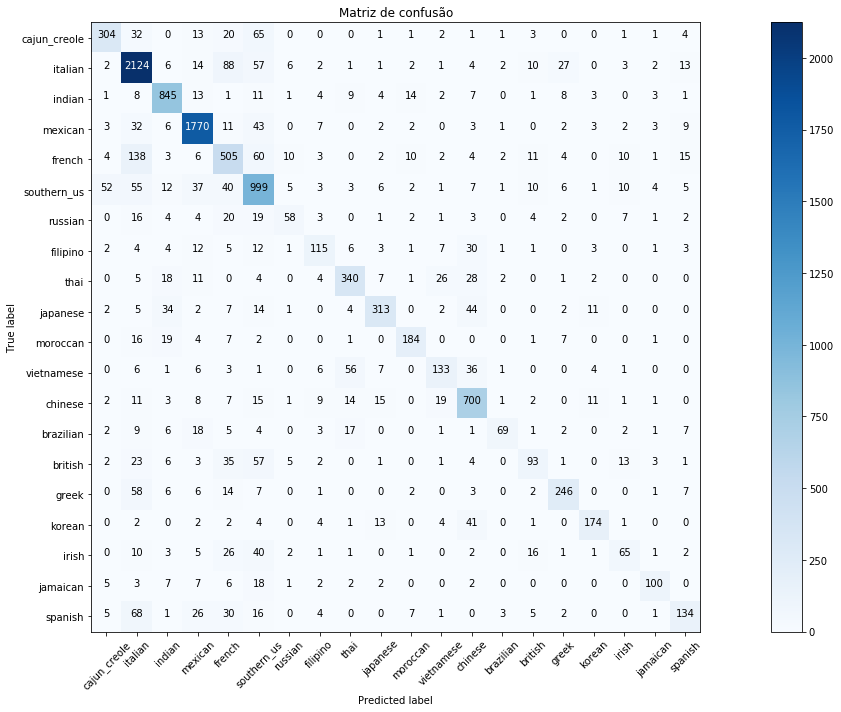

In [56]:
cnf_matrix = confusion_matrix(test['cuisine'], y_test_decoded, labels=test['cuisine'].unique())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=test['cuisine'].unique(),title='Matriz de confusão')

Discussões sobre os resultados obtidos e apresentados aqui serão realizadas no relatório final do projeto.